A solution to Euler's equations using Godunov's scheme and the HLLC Riemann solver.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
gamma = 1.4  #razão dos calores específicos para o ar

def flux(U):
    rho = U[0]

    if rho > 1e-8:
      u = U[1] / rho

    else:
      u = 0.0

    E = U[2] #energia total
    p = (E - 0.5 * rho * u**2) * (gamma - 1) #pressão, (gamma-1) sendo um fator de correção * energia interna

    F = np.zeros_like(U)
    F[0] = rho * u
    F[1] = rho * u**2 + p
    F[2] = u * (E + p)

    return F

def primitive_vars(U):
    #definindo a densidade, a velocidade e a pressão
    rho = U[0]
    u = U[1] / rho if rho > 1e-8 else 0.0
    E = U[2]
    p = (gamma - 1) * (E - 0.5 * rho * u**2)
    return rho, u, p

In [ ]:
def hllc(U_L, U_R):
    rho_L, u_L, p_L = primitive_vars(U_L)
    rho_R, u_R, p_R = primitive_vars(U_R)

    #velocidade do som
    if rho_L > 1e-8:
        a_L = np.sqrt(gamma * p_L / rho_L)
    else:
        a_L = 0.0

    if rho_R > 1e-8:
        a_R = np.sqrt(gamma * p_R / rho_R)
    else:
        a_R = 0.0

    #estimativas para a velocidade de onda
    S_L = min(u_L - a_L, u_R - a_R)
    S_R = max(u_L + a_L, u_R + a_R)

    #velocidade média (S_M)
    denom = rho_L * (S_L - u_L) - rho_R * (S_R - u_R)
    if abs(denom) > 1e-8:
        S_M = (p_R - p_L + rho_L * u_L * (S_L - u_L) - rho_R * u_R * (S_R - u_R)) / denom
    else:
        S_M = 0.0

    F_L = flux(U_L)
    F_R = flux(U_R)

    if S_L >= 0:
        return F_L
    elif S_R <= 0:
        return F_R
    else:
        denom_L = S_L - S_M
        denom_R = S_R - S_M

        if abs(denom_L) > 1e-8:
            U_M_L = rho_L * (S_L - u_L) / denom_L * np.array([
                1,
                S_M,
                U_L[2] / rho_L + (S_M - u_L) * (S_M + p_L / (rho_L * (S_L - u_L)))
            ])
        else:
            U_M_L = np.array([rho_L, rho_L * u_L, U_L[2]])

        if abs(denom_R) > 1e-8:
            U_M_R = rho_R * (S_R - u_R) / denom_R * np.array([
                1,
                S_M,
                U_R[2] / rho_R + (S_M - u_R) * (S_M + p_R / (rho_R * (S_R - u_R)))
            ])
        else:
            U_M_R = np.array([rho_R, rho_R * u_R, U_R[2]])

        if S_M >= 0:
            return F_L + S_L * (U_M_L - U_L)
        else:
            return F_R + S_R * (U_M_R - U_R)

In [ ]:
#parâmetros
Nx = 100
Nt = 100
L = 1.0
dx = L / Nx
dt = 0.001
x = np.linspace(0, L, Nx)

#initial conditions
#U[0] densidade ρ, U[1] momento μ, U[2] energia total E do sistema. separa-se "à esquerda" e "à direita" (do choque)
U = np.zeros((3, Nx))
U[0, :int(Nx/2)] = 1.0
U[0, int(Nx/2):] = 0.125
U[1, :int(Nx/2)] = 0.0
U[1, int(Nx/2):] = 0.0
U[2, :int(Nx/2)] = 2.5
U[2, int(Nx/2):] = 0.25

for t in range(Nt):
    U_new = np.zeros_like(U)
    for i in range(1, Nx-1):
        F_left = hllc(U[:, i-1], U[:, i])
        F_right = hllc(U[:, i], U[:, i+1])
        U_new[:, i] = U[:, i] - dt / dx * (F_right - F_left)

    #boundary conditions
    U_new[:, 0] = U_new[:, 1]
    U_new[:, -1] = U_new[:, -2]

    U = U_new.copy()

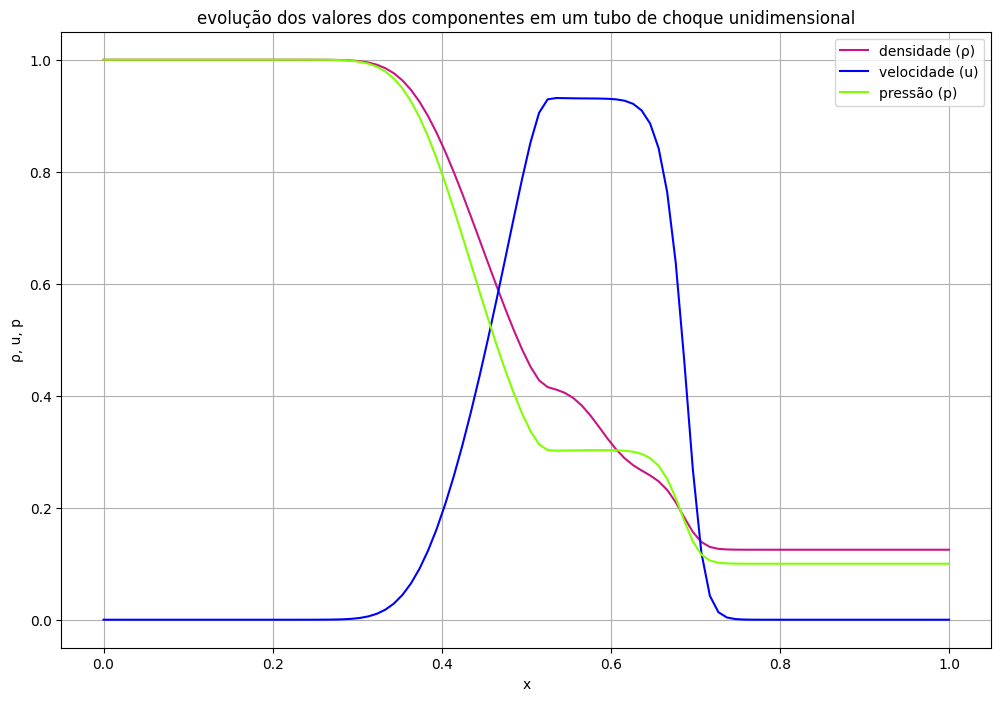

In [ ]:
rho = U[0]
u = U[1] / rho
p = (gamma - 1) * (U[2] - 0.5 * rho * u**2)

plt.figure(figsize=(12, 8))
plt.plot(x, rho, label='densidade (ρ)', color='mediumvioletred')
plt.plot(x, u, label='velocidade (u)', color='blue')
plt.plot(x, p, label='pressão (p)', color='chartreuse')
plt.xlabel('x')
plt.ylabel('ρ, u, p')
plt.title('evolução dos valores dos componentes em um tubo de choque unidimensional')
plt.legend()
plt.grid()
plt.show()